# Homework 4 Machine Learning Zoomcamp

This file is created to answer homework 4 of Machine Learning Zoomcamp.  
We use the lead scoring dataset of Bank Marketing dataset that can be downloaded from [here.](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv)  
In this dataset our desired target for classification task will be ***converted*** variable - has the client signed up to the platform or not.

In [1]:
#importing all necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline 

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mutual_info_score
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression


In [2]:
#downloading the data
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

--2025-10-21 15:48:16--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv’

course_lead_scoring 100%[===================>]  78.98K   104KB/s    in 0.8s    

2025-10-21 15:48:18 (104 KB/s) - ‘course_lead_scoring.csv’ saved [80876/80876]



## Data preparation

   * Check if the missing values are presented in the features.
   * If there are missing values:
       - For caterogiral features, replace them with 'NA'
       - For numerical features, replace with with 0.0

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [2]:
#reading the dataset and assign to a dataframe
df = pd.read_csv('course_lead_scoring.csv')

#checking the missing values
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [3]:
#check the datatype of each column
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [4]:
#replacing  missing values for categorical features with 'NA'
cat_cols = ['lead_source', 'industry', 'employment_status', 'location']
df[cat_cols] = df[cat_cols].fillna('NA')

#replacing missing values for numerical features with 0.0
df['annual_income'] = df['annual_income'].fillna(0.0)

#checking the missing values after replacement
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [5]:
#we're going split data into 3 parts, so we'll use the train_test_split twice. The first one the train + val combined into full test
#and test set. The second one we split full test into train and validation.
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 1)

#the test size below is 0.25 or 25% from df_full_train (which is 80% of overall df) that equals to 20% of overall df
#so 20% val / 80% full train = 1/4 = 25%
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 42)



In [6]:
#check the length of all data
len(df_train), len(df_val), len(df_test)

(876, 293, 293)

In [7]:
#reset the shuffled index of each part of dataset
df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

#setting the target variable ('converted') as a new 1D array
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

#deleting target values in dataframe to avoid mistakes in the future
del df_train['converted']
del df_val['converted']
del df_test['converted']

In [8]:
#separating categorical and numerical data in our dataset. Numerical for column in int and float data types,
#categorical for column with object data type, except the desired target 'converted'
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']
categorical = ['lead_source', 'industry','employment_status', 'location']

Reference:

   * the DictVectorizer [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html)
   * pd.DataFrame.to_dict [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_dict.html)

## Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

   * For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
   * Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['balance'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

   * lead_score
   * number_of_courses_viewed
   * interaction_count
   * annual_income


In [9]:
#calculate ROC AUC for numerical variables
for i in numerical:
    auroc_temp = roc_auc_score(y_train, df_train[i])
    if auroc_temp < 0.5:
        auroc_temp = roc_auc_score(y_train, -df_train[i])
    print(f'AUROC of {i} : {auroc_temp}')

AUROC of number_of_courses_viewed : 0.7635680590007088
AUROC of annual_income : 0.5519578313253012
AUROC of interaction_count : 0.738270176293409
AUROC of lead_score : 0.6144993577250176


**Answer**: numerical variable with the highest AUC is ***number_of_courses_viewed***

## Question 2: Training the model

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

What's the AUC of this model on the validation dataset? (round to 3 digits)

   * 0.32
   * 0.52
   * 0.72
   * 0.92

In [10]:
#One-hot-encoding using DictVectorizer
dv = DictVectorizer(sparse = False)

train_dict = df_train[numerical + categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[numerical + categorical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [11]:
#Logistic Regression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [12]:
# Make predictions on the validation dataset 
y_pred = model.predict_proba(X_val)[:, 1]

In [13]:
# Calculate AUC of this model on the validation dataset (round to 3 digits)
auc_val = round(roc_auc_score(y_val, y_pred), 3)
print(auc_val)

0.817


**Answer**: It falls between ***0.72 and 0.92***.

## Question 3: Precision and Recall

Now let's compute precision and recall for our model.

    * Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
    * For each threshold, compute precision and recall
    * Plot them

At which threshold precision and recall curves intersect?

    * 0.145
    * 0.345
    * 0.545
    * 0.745


In [16]:
# function to obtain a dataframe with True Negative (TN), False Negative (FN), True Positive (TP), False Positive (FP), and recall values
# at threshold from 0.0 to 1.0 with step 0.01
def pr_dataframe(y_val, y_pred):
    scores = []

    threshold = np.linspace(0, 1, 101)

    for t in threshold:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, tn, fn))

    columns = ['threshold', 'tp', 'fp', 'tn', 'fn']

    df_scores = pd.DataFrame(scores, columns = columns)

    df_scores['precision'] = df_scores['tp'] / (df_scores['tp'] + df_scores['fp'])
    df_scores['recall'] = df_scores['tp'] / (df_scores['tp'] + df_scores['fn'])

    return df_scores
        

In [17]:
#get the dataframe with function
pr_curve_df = pr_dataframe(y_val, y_pred)

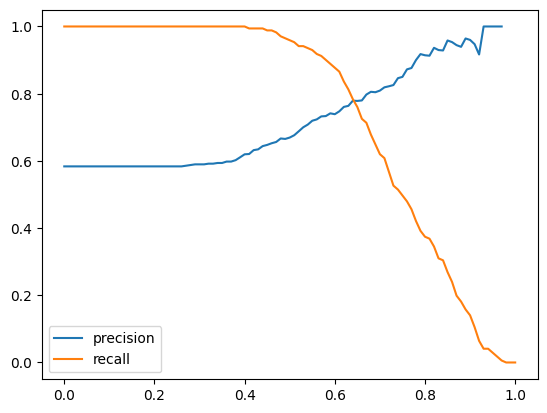

In [18]:
#create the precision recall curve
plt.plot(pr_curve_df.threshold, pr_curve_df.precision, label = 'precision')
plt.plot(pr_curve_df.threshold, pr_curve_df.recall, label = 'recall')
plt.legend()

**Answer**: the curves intersect at ***0.6-ish***.

## Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1 = 2*(P * R) / (P + R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

   * 0.14
   * 0.34
   * 0.54
   * 0.74


In [21]:
pr_curve_df['F1_score'] = 2*((pr_curve_df['precision'] * pr_curve_df['recall']) / (pr_curve_df['precision'] + pr_curve_df['recall']))
f1_score_max = pr_curve_df[pr_curve_df['F1_score'] == pr_curve_df['F1_score'].max()]
f1_score_max

,threshold,tp,fp,tn,fn,precision,recall,F1_score
57,0.57,156,57,65,15,0.732394,0.912281,0.8125


**Answer**: the threshold at which F1 maximal is ***0.57***.

## Question 5: 5-Fold CV

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)

  *  Iterate over different folds of df_full_train
  *  Split the data into train and validation
  *  Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
  *  Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

   * 0.0001
   * 0.006
   * 0.06
   * 0.36


In [29]:
#function for training LogReg model
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [37]:
#function for predicting values
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [38]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print(f'Mean: {round(np.mean(scores), 4)} \n Std: {round(np.std(scores), 4)}')
    

Mean: 0.8221 
 Std: 0.0358


**Answer**: Std across different folds is ***0.0358***

## Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter C

   * Iterate over the following C values: [0.000001, 0.001, 1]
   * Initialize KFold with the same parameters as previously
   * Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
   * Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

   * 0.000001
   * 0.001
   * 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [41]:
for c in [0.000001, 0.001, 1]:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train, C=c)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (c, np.mean(scores), np.std(scores)))
    

C=1e-06 0.822 +- 0.036
C=0.001 0.822 +- 0.036
C=1 0.822 +- 0.036


**Answer**: all c are equally good, so I pick the smallest one which is ***0.000001***